In [144]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-pj8oz1q6
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-pj8oz1q6
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [146]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import csv
import utils

##configuration

In [147]:
csv_file='/content/GradCAM-Dataset/train.csv'

In [148]:
dataset_dir='/content/GradCAM-Dataset/'

In [149]:
DEVICE='cuda'

In [150]:
batch_size=32
learning_rate=0.0001
epoches=30


In [151]:
data=pd.read_csv(csv_file)

In [152]:
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [153]:
train_df,valid_df=train_test_split(data,test_size=0.2,random_state=42)

##Augmentation 

In [154]:
train_augs=A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])


])

valid_augs=A.Compose([
    A.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])


])

##Load Image DataSet

In [155]:
trainset=utils.ImageDataset(train_df , augs=train_augs , data_dir=dataset_dir)
validset=utils.ImageDataset(valid_df  , augs=valid_augs ,data_dir=dataset_dir)

In [156]:
image1,label=trainset[0]

In [157]:
image1.shape

torch.Size([3, 227, 227])

In [158]:
class_list=['cucumber','eggplant','mushrom']

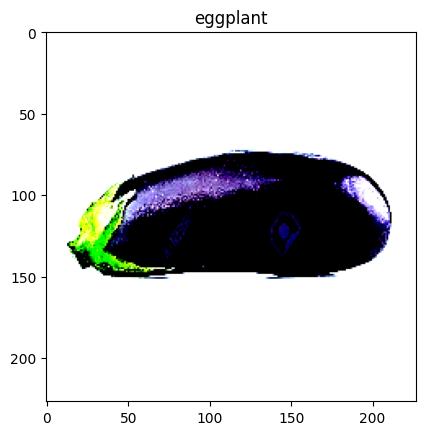

In [159]:
plt.imshow(image1.permute(1,2,0))
plt.title(class_list[label])
plt.show()

In [160]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


##Load dataset  in batches

In [161]:
trainloader=DataLoader(trainset , batch_size , shuffle=True)
validloader=DataLoader(validset , batch_size , shuffle=False)

In [162]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 5
No. of batches in validloader : 2


In [163]:
for images,labels in trainloader:
  break
print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([32, 3, 227, 227])
One batch label shape : torch.Size([32])


In [164]:
from torch.nn.modules.pooling import MaxPool2d

##Createw Model

In [165]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel , self).__init__()

    self.feature_extractor=nn.Sequential(
        nn.Conv2d(in_channels=3 , out_channels=16 , kernel_size=(5,5) , padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),


        nn.Conv2d(in_channels=16 , out_channels=16 , kernel_size=(5,5) , padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),


        nn.Conv2d(in_channels=16 , out_channels=32 , kernel_size=(5,5) , padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4,4), stride=2),


        nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=(5,5) , padding=1),
        nn.ReLU()
        
    )

    self.maxpool=nn.MaxPool2d(kernel_size=(4,4), stride=2)

    self.classifier=nn.Sequential(
        
        nn.Flatten(),
        nn.Linear(6400 , 2048) , 
        nn.ReLU(),
        nn.Linear(2048 , 3)


    )

    self.gradient=None

  def activations_hook(self , grad):
    self.gradient=grad


  def forward(self , images):
    x=self.feature_extractor(images) # activation maps

    h=x.register_hook(self.activations_hook)

    x=self.maxpool(x)
    x=self.classifier(x)

    return x


  def get_activation_gradient(self):#a1 , a2 , a3 ,....
    return self.gradient

  def get_activation_map(self , x): #A1 , A2 , A3 ,.....
    return self.feature_extractor(x)


In [166]:
model=ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

##Train and Eval functions

In [167]:
def train_fn(dataloader , model , optimizer , creterion):

  model.train()
  total_loss=0.0
  for image,label in tqdm(dataloader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)


    optimizer.zero_grad()
    logits = model(image)

    loss=creterion(logits,label)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()

  return total_loss/len(dataloader)





In [168]:
def valid_fn(dataloader , model ,  creterion):

  model.eval()
  total_loss=0.0
  for image,label in tqdm(dataloader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)



    logits = model(image)

    loss=creterion(logits,label)


    total_loss+=loss.item()

  return total_loss/len(dataloader)





##Training loop

In [169]:
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
creterion=torch.nn.CrossEntropyLoss()


In [170]:
best_valid_loss=np.Inf

for i in range(epoches):
  train_loss=train_fn(trainloader , model , optimizer , creterion)
  valid_loss=valid_fn(validloader , model , creterion)


  if valid_loss<best_valid_loss:
    torch.save(model.state_dict() , 'best weights.pt')
    best_valid_loss=valid_loss
    print("saved weights success")

  print(f"epoch {i+1} train loss{train_loss} valid loss:{valid_loss} ")

100%|██████████| 2/2 [00:00<00:00, 10.04it/s]


saved weights success
epoch 1 train loss1.0549902439117431 valid loss:1.0814232230186462 


100%|██████████| 2/2 [00:00<00:00, 23.18it/s]


saved weights success
epoch 2 train loss0.9481183052062988 valid loss:0.8170076012611389 


100%|██████████| 2/2 [00:00<00:00, 21.68it/s]


saved weights success
epoch 3 train loss0.8287508130073548 valid loss:0.7085531055927277 


100%|██████████| 2/2 [00:00<00:00, 25.28it/s]


saved weights success
epoch 4 train loss0.6991168022155761 valid loss:0.49813441932201385 


100%|██████████| 2/2 [00:00<00:00, 24.86it/s]


saved weights success
epoch 5 train loss0.582461017370224 valid loss:0.3745390325784683 


100%|██████████| 2/2 [00:00<00:00, 25.50it/s]


saved weights success
epoch 6 train loss0.44670523405075074 valid loss:0.2702172324061394 


100%|██████████| 2/2 [00:00<00:00, 23.43it/s]


saved weights success
epoch 7 train loss0.32245394587516785 valid loss:0.22400273382663727 


100%|██████████| 2/2 [00:00<00:00, 25.24it/s]


saved weights success
epoch 8 train loss0.23688332438468934 valid loss:0.19391844794154167 


100%|██████████| 2/2 [00:00<00:00, 25.35it/s]


saved weights success
epoch 9 train loss0.200983464717865 valid loss:0.167748361825943 


100%|██████████| 2/2 [00:00<00:00, 24.20it/s]


saved weights success
epoch 10 train loss0.19961825162172317 valid loss:0.14021939504891634 


100%|██████████| 2/2 [00:00<00:00, 14.39it/s]


epoch 11 train loss0.15981112122535707 valid loss:0.15758884325623512 


100%|██████████| 2/2 [00:00<00:00,  6.57it/s]


epoch 12 train loss0.13074211478233339 valid loss:0.16108237765729427 


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


saved weights success
epoch 13 train loss0.08724424466490746 valid loss:0.07155826780945063 


100%|██████████| 2/2 [00:00<00:00, 12.15it/s]


epoch 14 train loss0.09373105317354202 valid loss:0.1127624399960041 


100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


epoch 15 train loss0.05586504302918911 valid loss:0.178431642241776 


100%|██████████| 2/2 [00:00<00:00, 14.76it/s]


epoch 16 train loss0.05448799543082714 valid loss:0.10954549349844456 


100%|██████████| 2/2 [00:00<00:00, 13.90it/s]


epoch 17 train loss0.037230388075113294 valid loss:0.1260371459648013 


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


epoch 18 train loss0.04246051050722599 valid loss:0.1192483501508832 


100%|██████████| 2/2 [00:00<00:00, 13.06it/s]


epoch 19 train loss0.04151545166969299 valid loss:0.19424420641735196 


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]


epoch 20 train loss0.022293103300035 valid loss:0.07179829524829984 


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


epoch 21 train loss0.03359091002494097 valid loss:0.09449827205389738 


100%|██████████| 2/2 [00:00<00:00, 15.70it/s]


epoch 22 train loss0.03186660632491112 valid loss:0.09095622878521681 


100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


saved weights success
epoch 23 train loss0.018468787148594856 valid loss:0.03024005552288145 


100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


epoch 24 train loss0.02853765357285738 valid loss:0.057290447410196066 


100%|██████████| 2/2 [00:00<00:00, 23.49it/s]


epoch 25 train loss0.03318718150258064 valid loss:0.14483899250626564 


100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


epoch 26 train loss0.032891617715358736 valid loss:0.042823978466913104 


100%|██████████| 2/2 [00:00<00:00, 26.06it/s]


epoch 27 train loss0.030850940197706223 valid loss:0.06872023176401854 


100%|██████████| 2/2 [00:00<00:00, 23.96it/s]


epoch 28 train loss0.01521507278084755 valid loss:0.09611670637968928 


100%|██████████| 2/2 [00:00<00:00, 21.73it/s]


epoch 29 train loss0.02037987974472344 valid loss:0.0921188504435122 


100%|██████████| 2/2 [00:00<00:00, 19.02it/s]


saved weights success
epoch 30 train loss0.011781451851129532 valid loss:0.023521426832303405 


##Get GridMap

In [173]:
def get_gridcam(model , image ,label , size):
  label.backward()
  gradients=model.get_activation_gradient()
  pooled_gradient=torch.mean(gradients ,dim=[0,2,3])
  activations=model.get_activation_map(image).detach()

  for i in range(activations.shape[1]):
    activations[:,i,:,:]*=pooled_gradient[i]
    
  heatmap=torch.mean(activations,dim=1).squeeze().cpu()
  heatmap=nn.ReLU()(heatmap)
  heatmap/=torch.max(heatmap)
  heatmap=cv2.resize(heatmap.numpy(),(size,size))
  return heatmap


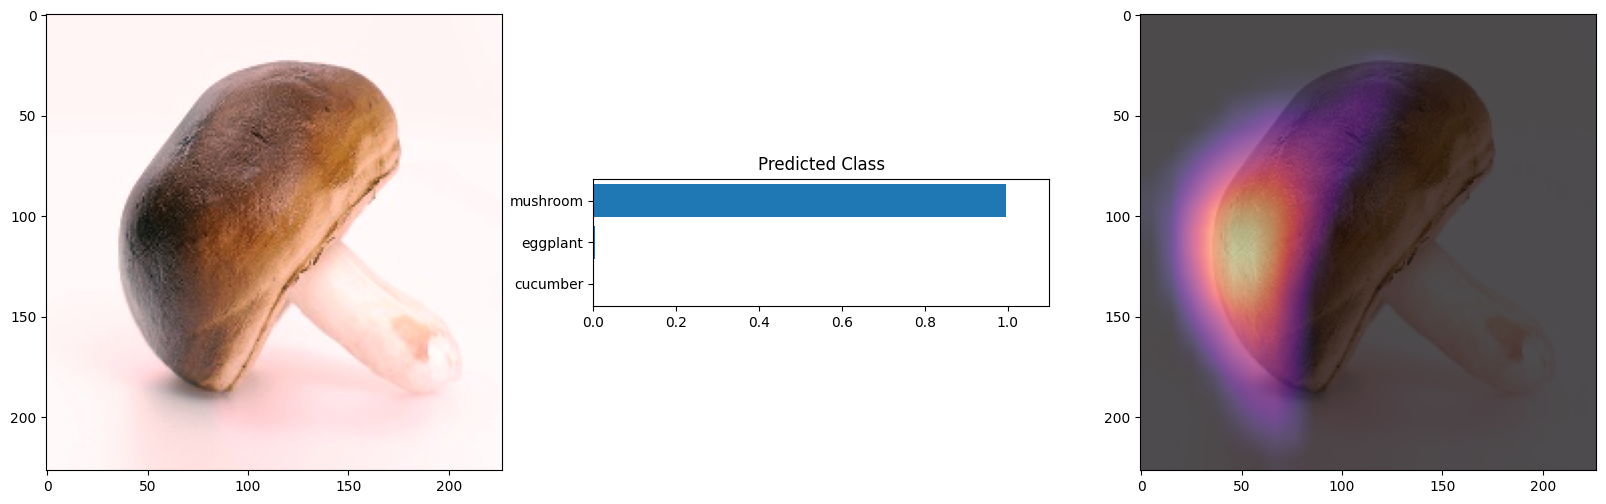

In [177]:
image,label=validset[2]

denorm_image=image.permute(1,2,0)*np.array((0.299, 0.224 ,0.225 ))+np.array((0.485 , 0.456 , 0.406))

image=image.unsqueeze(0).to(DEVICE)

pred=model(image)

heatmap=get_gridcam(model ,image, pred[0][1] ,size=227 )

utils.plot_heatmap(denorm_image , pred , heatmap)
